# **First model for the project**

# **Load lib**

In [21]:
# !pip install pyvi > /dev/null 2>&1 #install without notification

import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, Dense, Dropout,Softmax, Attention,BatchNormalization,Bidirectional,Add,Multiply ,Concatenate,LSTM, GRU, Input,MaxPooling1D, GlobalMaxPooling1D, LayerNormalization, Conv1D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pyvi import ViTokenizer
from pyvi import ViUtils
import tensorflow as tf
import re
import string
from underthesea import word_tokenize, text_normalize
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer



# **Load data**

## data set already saved as the link below:


In [22]:


df = pd.read_csv('data - data.csv')  # Read data from CSV file
label_mapping = {
    'NEG': "tiêu cực",
    'NEU': "trung lập",
    'POS': "tích cực"
}
df['label'] = df['label'].map(label_mapping)

# Drop the 'Unnamed: 3' column
df = df.drop(columns=['Unnamed: 3', 'rate'])

# Remove duplicate rows
df = df.drop_duplicates().reset_index(drop=True)
df


,comment,label
0,Áo bao đẹp ạ!!,tích cực
1,Tuyệt vời !,tích cực
2,2day ao khong giong trong.,tiêu cực
3,"Mùi thơm,bôi lên da mềm da.",tích cực
4,"Vải đẹp, dày dặn.",tích cực
...,...,...
27084,"Chất tốt, Shop phục vụ rất tốt.",tích cực
27085,"Hàng y hình, đóng gói ko cẩn thận nên quả ngực...",trung lập
27086,Hàng đẹp đúng giá tiền.,tích cực
27087,Chất vải khá ổn.,tích cực


# **Data preparation and preprocessing for tranning**

# data separation as Input_label and input_data



### Input_label: target variable

In [23]:
input_label = df['label']
input_label

0         tích cực
1         tích cực
2         tiêu cực
3         tích cực
4         tích cực
           ...    
27084     tích cực
27085    trung lập
27086     tích cực
27087     tích cực
27088     tích cực
Name: label, Length: 27089, dtype: object

### input_data: data features

In [24]:
input_data = df['comment']
input_data

0                                           Áo bao đẹp ạ!!
1                                              Tuyệt vời !
2                               2day ao khong giong trong.
3                              Mùi thơm,bôi lên da mềm da.
4                                        Vải đẹp, dày dặn.
                               ...                        
27084                      Chất tốt, Shop phục vụ rất tốt.
27085    Hàng y hình, đóng gói ko cẩn thận nên quả ngực...
27086                              Hàng đẹp đúng giá tiền.
27087                                     Chất vải khá ổn.
27088    áo rất ok nhé , vải mịn , len cao cổ này phối ...
Name: comment, Length: 27089, dtype: object

**Data Preprocessing**




In [25]:
def preprocess_vietnamese_text(text):
    """
    Comprehensive text preprocessing pipeline for Vietnamese text that combines
    emoji removal, text cleaning, and Vietnamese-specific tokenization.
    
    Args:
        text (str): Input text to be preprocessed
        
    Returns:
        str: Cleaned and tokenized text
    """
    # Define emoji pattern
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
    "]+", flags=re.UNICODE)
    
    # Initial cleaning steps
    text = text.lower()  # lowercase text
    text = re.sub(emoji_pattern, " ", text)  # remove emojis
    text = re.sub(r'([a-z]+?)\1+', r'\1', text)  # reduce repeated characters
    
    # Handle punctuation with spacing
    text = re.sub(r"(\w)\s*([" + string.punctuation + "])\s*(\w)", r"\1 \2 \3", text)
    text = re.sub(r"(\w)\s*([" + string.punctuation + "])", r"\1 \2", text)
    text = re.sub(f"([{string.punctuation}])([{string.punctuation}])+", r"\1", text)
    
    # Clean up edges
    text = text.strip()
    while text.endswith(tuple(string.punctuation + string.whitespace)):
        text = text[:-1]
    while text.startswith(tuple(string.punctuation + string.whitespace)):
        text = text[1:]
    
    # Remove punctuation and normalize spaces
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r"\s+", " ", text)
    
    # Vietnamese-specific processing
    text = text_normalize(text)  # normalize Vietnamese text
    text = word_tokenize(text, format="text")  # tokenize using underthesea
    text = ViTokenizer.tokenize(text)  # additional tokenization using ViTokenizer
    
    return text

def process_dataset(input_data, input_labels=None):

    processed_texts = []
    processed_labels = []
    
    label_dict = {'tiêu cực': 0, 'trung lập': 1, 'tích cực': 2}
    
    for idx, text in enumerate(input_data):
        # Process the text
        processed_text = preprocess_vietnamese_text(text)
        processed_texts.append(processed_text)
        
        # Process the label if provided
        if input_labels is not None and idx < len(input_labels):
            if isinstance(input_labels[idx], str):
                processed_labels.append(label_dict.get(input_labels[idx], input_labels[idx]))
            else:
                processed_labels.append(input_labels[idx])
    
    if input_labels is not None:
        return processed_texts, processed_labels
    return processed_texts


data_preprocessed, label_preprocess = process_dataset(input_data=input_data.tolist(), input_labels=input_label.tolist())



In [26]:
#In here, I use some basic functions to preprocessing data for the model
#Cause Vietnamese has accents so I use ViTokenizer in libraly pyvi, for example "xin chào" should be sticked together like  "xin_chào"
label_dict = {'tiêu cực':0, 'trung lập':1, 'tích cực':2}

for i in range(5):
    print(i)
    print(f"Original: {input_data[i]}\nProcessed: {data_preprocessed[i]}\n")
    print(f"Original: {input_label[i]}\nProcessed: {label_preprocess[i]}\n")
#After processing, the data has basically been processed at the most basic level for the model.

0
Original: Áo bao đẹp ạ!!
Processed: áo bao đẹp ạ

Original: tích cực
Processed: 2

1
Original: Tuyệt vời !
Processed: tuyệt_vời

Original: tích cực
Processed: 2

2
Original: 2day ao khong giong trong.
Processed: 2 day ao khong_giong trong

Original: tiêu cực
Processed: 0

3
Original: Mùi thơm,bôi lên da mềm da.
Processed: mùi thơm bôi lên da mềm da

Original: tích cực
Processed: 2

4
Original: Vải đẹp, dày dặn.
Processed: vải đẹp dày_dặn

Original: tích cực
Processed: 2



## After processing data, we start visualize length of sentences for next steps

<function matplotlib.pyplot.show(close=None, block=None)>

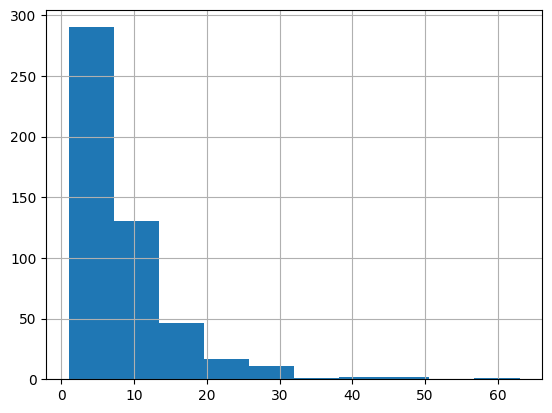

In [27]:
seq_len= [len(i.split()) for i in data_preprocessed[0:500]]
pd.Series(seq_len).hist(bins=10)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

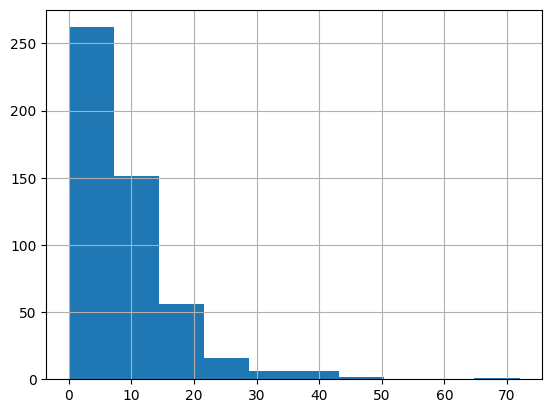

In [28]:
seq_len= [len(i.split()) for i in data_preprocessed[500:1000]]
pd.Series(seq_len).hist(bins=10)
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

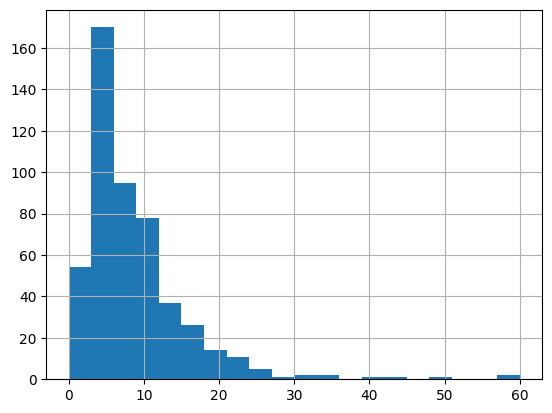

In [29]:
seq_len= [len(i.split()) for i in data_preprocessed[1000:1500]]
pd.Series(seq_len).hist(bins = 20)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

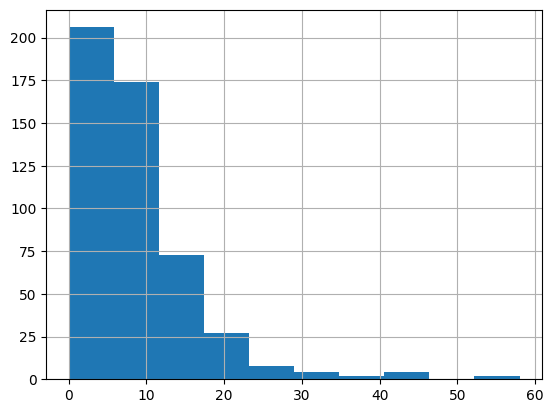

In [30]:
seq_len= [len(i.split()) for i in data_preprocessed[1500:2000]]
pd.Series(seq_len).hist(bins=10)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

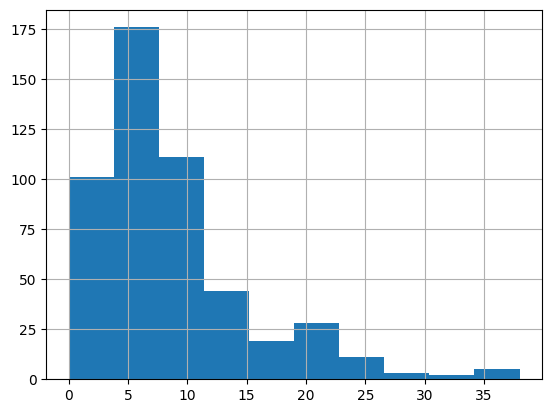

In [31]:
seq_len= [len(i.split()) for i in data_preprocessed[2000:2500]]
pd.Series(seq_len).hist(bins=10)
plt.show

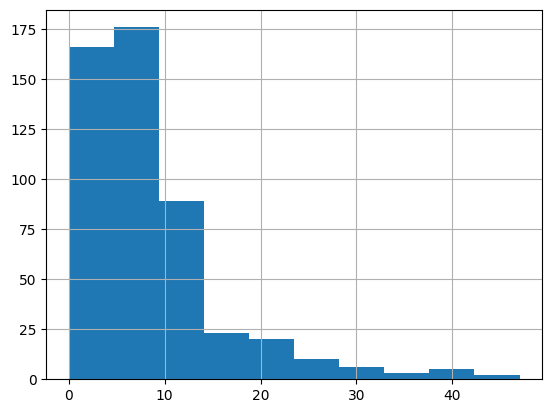

In [32]:
seq_len= [len(i.split()) for i in data_preprocessed[2500:3000]]
pd.Series(seq_len).hist(bins=10)
plt.show()

Feature Extraction


In [33]:

#As we can see in 6 charts, an average sentence has about 250 words, so we use it!
lable_tf =tf.keras.utils.to_categorical(label_preprocess,num_classes=3)
# Output:
# [[0., 0., 1.],  # One-hot encoding for '2'
#  [0., 1., 0.],  # One-hot encoding for '1'
#  [1., 0., 0.]]  # One-hot encoding for '0'

#In here, we use Tokenizer of tensorflow, running by data_preprocessed that already processed with ViTokenizer
tokenizer_data=Tokenizer(oov_token='<OOV>', filters='',split= ' ')
tokenizer_data.fit_on_texts(data_preprocessed)

tokenized_data_text = tokenizer_data.texts_to_sequences(data_preprocessed)
# Show the word index built by the tokenizer
print("Word Index:", tokenizer_data.word_index)

# Convert text to sequences of integers base on the order of the word index
sequences = tokenizer_data.texts_to_sequences(data_preprocessed)
print("Sequences:")
print(sequences)
#Now, every single word in the sentence will map to a vector of numbers with maxlen is 250
vec_data = pad_sequences(tokenized_data_text, padding='post', maxlen=250)
print("Sequences after padding:")
print(vec_data)

#Use pickle.dump to save it to reuse in fulture
pickle.dump(tokenizer_data, open("tokenizer_data.pkl", "wb"))

print("input data.shape",vec_data.shape)
data_vocab_size=len(tokenizer_data.word_index)+1
print("data_vocab_size",data_vocab_size)

#Use 70% for Tranning, 15% for Validation, 15% for Testing
# Single split for train, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(
    vec_data, lable_tf, test_size=0.3, random_state=26
)
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=26
)

# Split the data into training, validation, and testing sets
x_train_ml,x_temp_ml,y_train_ml,y_temp_ml=train_test_split(
    vec_data,label_preprocess,test_size=0.2,random_state=26
    )
x_val_ml,x_test_ml, y_val_ml, y_test_ml=train_test_split(
    x_temp_ml,y_temp_ml,test_size=0.5,random_state=26
    )
print('-------------Deep Learning-----------------')
print("Training sample",len(x_train))
print("Validation sample",len(x_val))
print("Test sample",len(x_test))
print('-------------Machine Learning-----------------')
print("Training sample",len(x_train_ml))
print("Validation sample",len(x_val_ml))
print("Test sample",len(x_test_ml))


Word Index: {'<OOV>': 1, 'rất': 2, 'đẹp': 3, 'sản_phẩm': 4, 'shop': 5, 'hàng': 6, 'chất_lượng': 7, 'giao': 8, 'áo': 9, 'và': 10, 'tuyệt_vời': 11, 'đóng_gói': 12, 'tiền': 13, 'tốt': 14, 'nhưng': 15, 'nhanh': 16, 'vải': 17, 'chắc_chắn': 18, 'đáng': 19, 'hơi': 20, 'phục_vụ': 21, 'thời_gian': 22, 'mình': 23, 'mua': 24, 'màu': 25, 'mặc': 26, 'lắm': 27, 'chất': 28, 'k': 29, 'ko': 30, 'có': 31, 'thì': 32, 'quá': 33, 'không': 34, 'được': 35, 'ok': 36, 'với': 37, 'mà': 38, 'như': 39, 'giá': 40, 'là': 41, 'cho': 42, 'bị': 43, '1': 44, 'hình': 45, 'nên': 46, 'sẽ': 47, 'luôn': 48, 'ạ': 49, 'cũng': 50, 'lại': 51, 'size': 52, 'giống': 53, 'hơn': 54, 'mỏng': 55, 'ủng_hộ': 56, 'cái': 57, 'lần': 58, 'còn': 59, 'nhiệt_tình': 60, 'nữa': 61, '2': 62, 'tạm': 63, 'rộng': 64, 'sp': 65, 'đc': 66, 'so': 67, 'sao': 68, 'của': 69, 'này': 70, 'quần': 71, 'đúng': 72, 'kém': 73, 'vừa': 74, 'đã': 75, 'đặt': 76, 'chỉ': 77, 'khá': 78, 'nhiều': 79, 'vẫn': 80, 'trong': 81, 'thích': 82, 'nhỏ': 83, 'rẻ': 84, '5': 85, 'nhậ

Fearture Extraction (TF-IDF approach)

In [34]:
tf_idf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf , temp, y_train_tfidf, temp_2 = train_test_split(
    data_preprocessed,label_preprocess,test_size=0.2,random_state=26
    )
X_val_tfidf, X_test_tfidf, y_val_tfidf, y_test_tfidf = train_test_split(
    temp, temp_2, test_size=0.5, random_state=26
)
X_data_tfidf = tf_idf_vectorizer.fit_transform(X_train_tfidf)
X_test_tfidf = tf_idf_vectorizer.transform(X_test_tfidf)
X_val_tfidf = tf_idf_vectorizer.transform(X_val_tfidf)
print(X_data_tfidf.shape)
print(len(X_train_tfidf))
#truncate the data to 335
TruncatedSVD_vector = TruncatedSVD(n_components=1000)
X_data_tfidf_truncated = TruncatedSVD_vector.fit_transform(X_data_tfidf)
X_test_tfidf_truncated = TruncatedSVD_vector.transform(X_test_tfidf)
X_val_tfidf_truncated = TruncatedSVD_vector.transform(X_val_tfidf)
y_train_tfidf_ = tf.keras.utils.to_categorical(y_train_tfidf,num_classes=3)
y_test_tfidf_ = tf.keras.utils.to_categorical(y_test_tfidf,num_classes=3)
y_val_tfidf_ = tf.keras.utils.to_categorical(y_val_tfidf,num_classes=3)
print(X_data_tfidf_truncated.shape)
print(X_test_tfidf_truncated.shape)

(21671, 5000)
21671
(21671, 1000)
(2709, 1000)


# DEEP LEARNING APPROACH

In [35]:
import tensorflow as tf

# Ensure TensorFlow uses the GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        print("GPU is being used.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected. Using CPU.")

# Model Definition
def create_model(vocab_size=data_vocab_size, max_length=250, num_classes=3):
    inputs = tf.keras.Input(shape=(max_length,))
    
    # Embedding Layer
    x = tf.keras.layers.Embedding(vocab_size, 32)(inputs)
    
    # CNN Branch
    conv1 = tf.keras.layers.Conv1D(32, 3, padding='same', activation='relu')(x)
    pool1 = tf.keras.layers.MaxPooling1D(2)(conv1)
    drop1 = tf.keras.layers.Dropout(0.2)(pool1)
    
    conv2 = tf.keras.layers.Conv1D(32, 3, padding='same', activation='relu')(drop1)
    pool2 = tf.keras.layers.MaxPooling1D(2)(conv2)
    
    # BiLSTM Branch with Attention
    bilstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(x)
    attention = tf.keras.layers.Attention()([bilstm, bilstm])
    add_layer = tf.keras.layers.Add()([bilstm, attention])
    pool_attention = tf.keras.layers.MaxPooling1D(2)(add_layer)
    
    # Normalize CNN Branch
    norm1 = tf.keras.layers.LayerNormalization()(pool2)
    drop2 = tf.keras.layers.Dropout(0.2)(norm1)
    
    # Global Pooling and Concatenate
    global_pool1 = tf.keras.layers.GlobalMaxPooling1D()(drop2)
    global_pool2 = tf.keras.layers.GlobalMaxPooling1D()(pool_attention)
    concat = tf.keras.layers.Concatenate()([global_pool1, global_pool2])
    
    # Final Dense Layers
    norm2 = tf.keras.layers.LayerNormalization()(concat)
    dense1 = tf.keras.layers.Dense(90, activation='relu')(norm2)
    drop3 = tf.keras.layers.Dropout(0.2)(dense1)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(drop3)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Create and compile model
model = create_model()
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)
model.summary()



No GPU detected. Using CPU.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 250)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 250, 32)   │    356,032 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 250, 32)   │      3,104 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 125, 32)   │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 125, 32)   │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 125, 32)   │      3,104 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 250, 64)   │     16,640 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 62, 32)    │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 250, 64)   │          0 │ bidirectional[0]… │
│ (Attention)         │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 62, 32)    │         64 │ max_pooling1d_1[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 250, 64)   │          0 │ bidirectional[0]… │
│                     │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 62, 32)    │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 125, 64)   │          0 │ add[0][0]         │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ dropout_1[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ max_pooling1d_2[… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 96)        │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 96)        │        192 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 90)        │      8,730 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 388,139 (1.48 MB)

 Trainable params: 388,139 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

Visualize the model

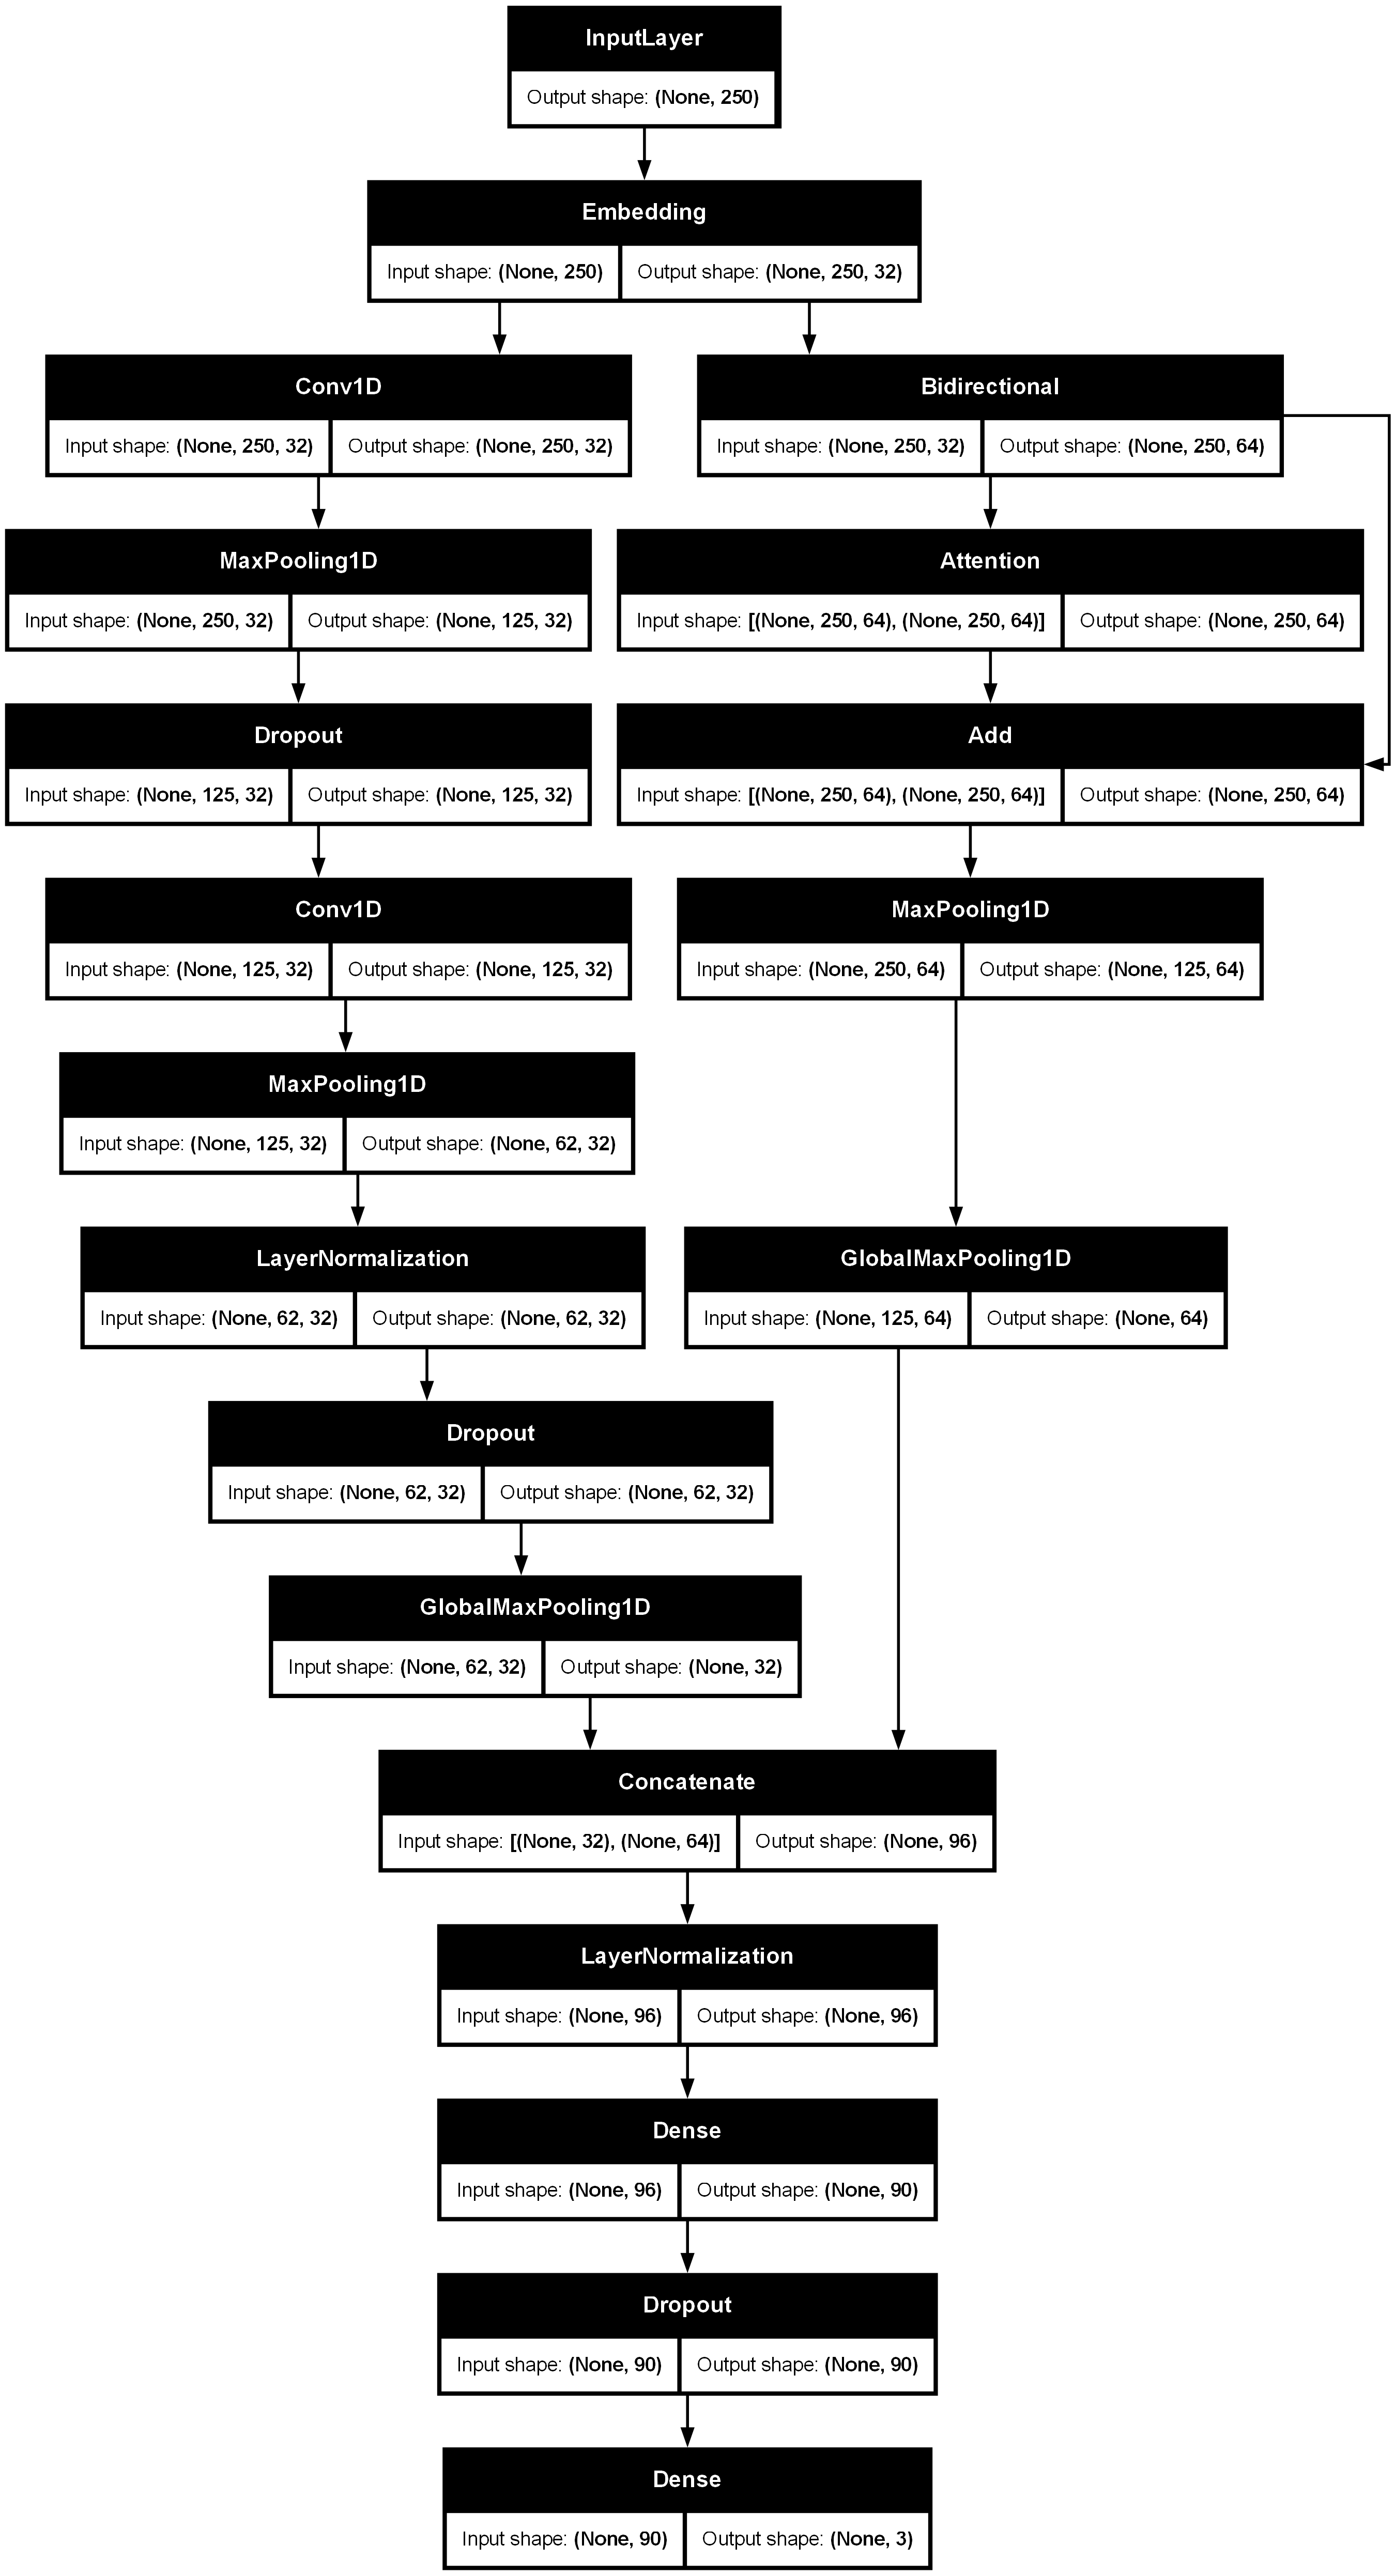

In [36]:
# import pydot
import graphviz
dot_img_file='model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [37]:
import tensorflow as tf

def create_tfidf_model(input_dim=1000, num_classes=3):
    """
        input_dim: Size of input features (1000 for TF-IDF)
        num_classes: Number of output classes (3)
    """
    inputs = tf.keras.Input(shape=(input_dim,))
    
    # First dense block
    x = tf.keras.layers.Dense(512, activation=None)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    # Second dense block with residual connection
    dense2 = tf.keras.layers.Dense(512, activation=None)(x)
    norm2 = tf.keras.layers.BatchNormalization()(dense2)
    act2 = tf.keras.layers.Activation('relu')(norm2)
    drop2 = tf.keras.layers.Dropout(0.3)(act2)
    add1 = tf.keras.layers.Add()([x, drop2])
    
    # Third dense block
    x = tf.keras.layers.Dense(256, activation=None)(add1)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    # Fourth dense block
    x = tf.keras.layers.Dense(128, activation=None)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    # Output layer
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    # Compile model with fixed learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create model
model_tfidf = create_tfidf_model()
model_tfidf.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │    512,512 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 512)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 512)       │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │    262,656 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 512)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 512)       │          0 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 512)       │          0 │ dropout_3[0][0],  │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │    131,328 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 256)       │          0 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     32,896 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_5[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 3)         │        387 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 945,411 (3.61 MB)

 Trainable params: 942,595 (3.60 MB)

 Non-trainable params: 2,816 (11.00 KB)

Visualize the model

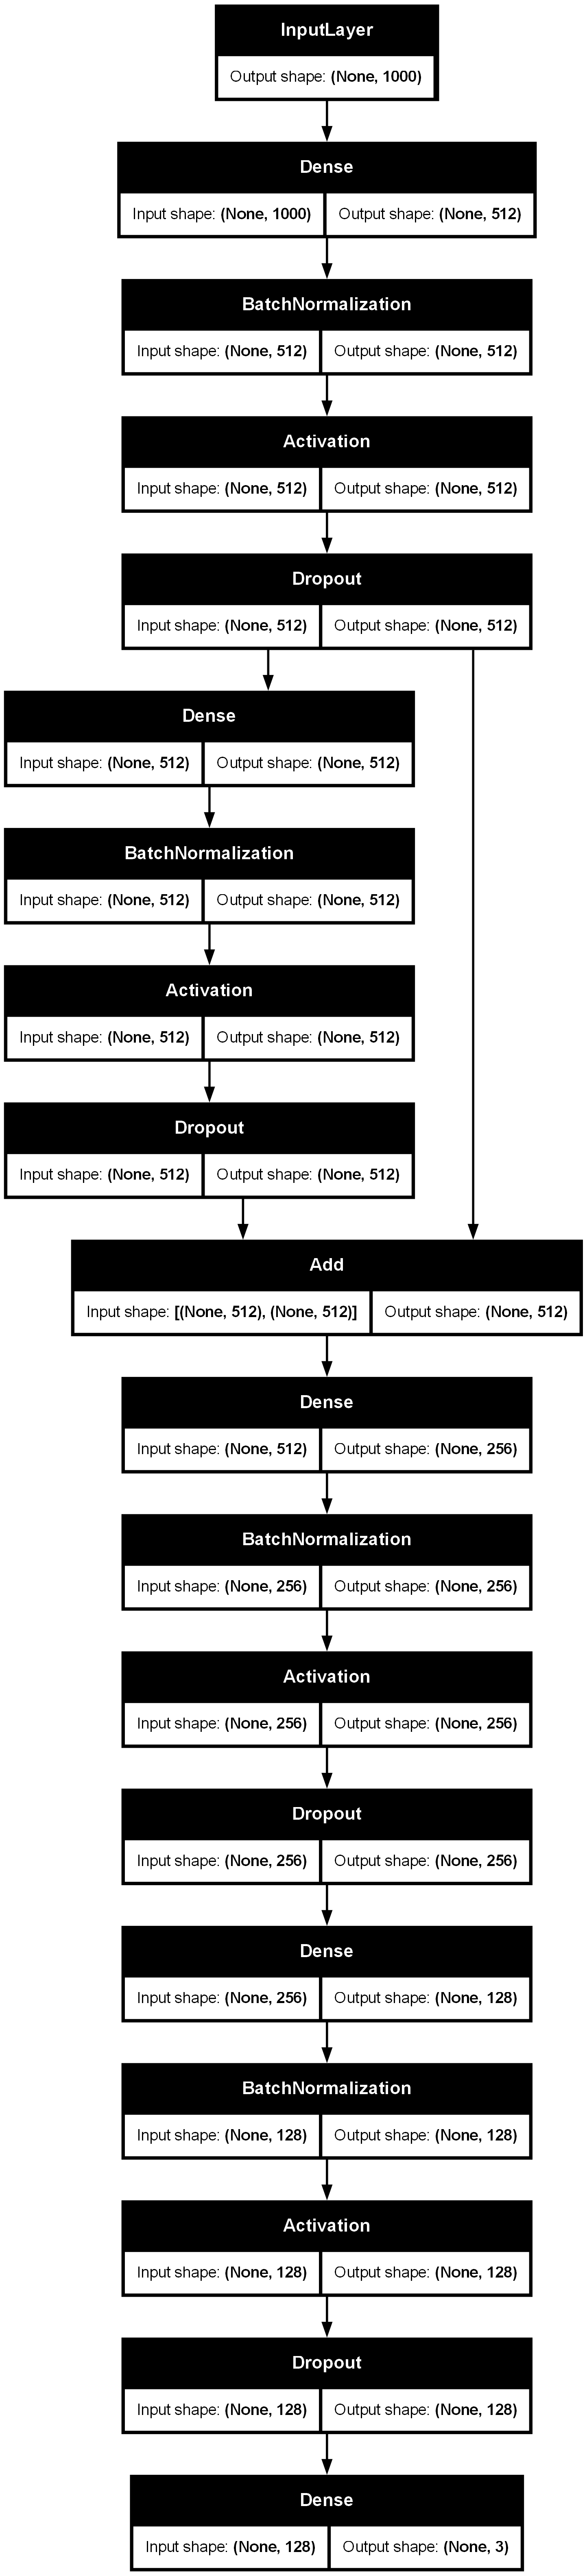

In [38]:
# import pydot
import graphviz
dot_img_file='model_2.png'
tf.keras.utils.plot_model(model_tfidf, to_file=dot_img_file, show_shapes=True)

In [39]:
import numpy as np

# Ensure data types are integers
x_train = x_train.astype(np.int32)
x_val = x_val.astype(np.int32)
y_train = y_train.astype(np.int32)
y_val = y_val.astype(np.int32)

# Verify the data shapes again
print("x_train shape:", x_train.shape, x_train.dtype)
print("y_train shape:", y_train.shape, y_train.dtype)
print("x_val shape:", x_val.shape, x_val.dtype)
print("y_val shape:", y_val.shape, y_val.dtype)
print("Max index in x_train:", np.max(x_train))
print("Max index in x_val:", np.max(x_val))

# Create datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(128).prefetch(tf.data.AUTOTUNE)

#this is tf_idf approach
train_dataset_tfidf = tf.data.Dataset.from_tensor_slices((X_data_tfidf_truncated, y_train_tfidf_))
train_dataset_tfidf = train_dataset_tfidf.shuffle(buffer_size=1024).batch(128).prefetch(tf.data.AUTOTUNE)


val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(128).prefetch(tf.data.AUTOTUNE)

val_dataset_tfidf = tf.data.Dataset.from_tensor_slices((X_val_tfidf_truncated, y_val_tfidf_))
val_dataset_tfidf = val_dataset_tfidf.batch(128).prefetch(tf.data.AUTOTUNE)
# Verify dataset shapes
print("\nVerifying dataset shapes:")
for features, labels in train_dataset.take(1):
    print("Batch features shape:", features.shape)
    print("Batch labels shape:", labels.shape)

for features, labels in train_dataset_tfidf.take(1):
    print("Batch features shape:", features.shape)
    print("Batch labels shape:", labels.shape)
    


x_train shape: (18962, 250) int32
y_train shape: (18962, 3) int32
x_val shape: (4063, 250) int32
y_val shape: (4063, 3) int32
Max index in x_train: 11123
Max index in x_val: 11125

Verifying dataset shapes:
Batch features shape: (128, 250)
Batch labels shape: (128, 3)
Batch features shape: (128, 1000)
Batch labels shape: (128, 3)


In [40]:


# Callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'best_token_model.keras',
        monitor='val_loss',
        save_best_only=True
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )
]
callbacks_tfidf = [
        tf.keras.callbacks.ModelCheckpoint(
        'deep_tfidf_model.keras',
        monitor='val_loss',
        save_best_only=True
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )
]

# Train the model
# model = create_tfidf_model(input_dim=335)
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 32s 184ms/step - accuracy: 0.5624 - loss: 1.0323 - val_accuracy: 0.7170 - val_loss: 0.6863 - learning_rate: 0.0010
Epoch 2/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 27s 180ms/step - accuracy: 0.7285 - loss: 0.6659 - val_accuracy: 0.7433 - val_loss: 0.6266 - learning_rate: 0.0010
Epoch 3/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 27s 180ms/step - accuracy: 0.7728 - loss: 0.5697 - val_accuracy: 0.7445 - val_loss: 0.6417 - learning_rate: 0.0010
Epoch 4/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 27s 182ms/step - accuracy: 0.7964 - loss: 0.5058 - val_accuracy: 0.7534 - val_loss: 0.6534 - learning_rate: 0.0010
Epoch 5/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 27s 182ms/step - accuracy: 0.8169 - loss: 0.4609 - val_accuracy: 0.7470 - val_loss: 0.6588 - learning_rate: 0.0010
Epoch 6/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 25s 171ms/step - accuracy: 0.8390 - loss: 0.4137 - val_accuracy: 0.7430 - val_loss: 0.6837 - learning_rate: 5.0000e-04
Epoch 7/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 25s 165ms/step - accuracy:

127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
Accuracy: 0.7559055118110236
              precision    recall  f1-score   support

           0       0.60      0.86      0.71       946
           1       0.38      0.05      0.09       680
           2       0.85      0.91      0.88      2438

    accuracy                           0.76      4064
   macro avg       0.61      0.61      0.56      4064
weighted avg       0.71      0.76      0.71      4064



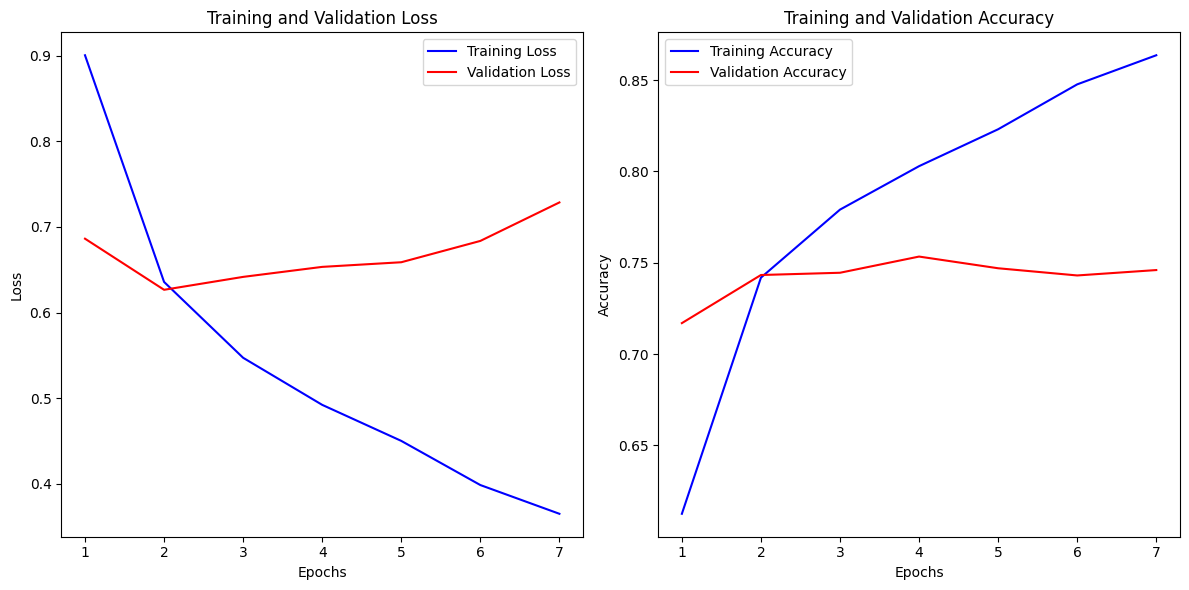

In [41]:
import matplotlib.pyplot as plt
y_pred = model.predict(x_test)
y_pred_classes = y_pred.argmax(axis=1)
y_test_classes = y_test.argmax(axis=1)

report = classification_report(y_test_classes, y_pred_classes)
print("Accuracy:", accuracy_score(y_test_classes, y_pred_classes))
print(report)


# Extract metrics from the history object
history_dict = history.history

# Loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Accuracy
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

# Number of epochs
epochs = range(1, len(loss) + 1)

# Plot Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [42]:
try:
    train_model = model_tfidf.fit(
        train_dataset_tfidf,
        validation_data=val_dataset_tfidf,
        epochs=10,
        callbacks=callbacks_tfidf
    )
except Exception as e:
    print(f"Error: {e}")


Epoch 1/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5616 - loss: 0.9834 - val_accuracy: 0.5939 - val_loss: 0.8988 - learning_rate: 5.0000e-04
Epoch 2/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7352 - loss: 0.6478 - val_accuracy: 0.6069 - val_loss: 0.8250 - learning_rate: 5.0000e-04
Epoch 3/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7613 - loss: 0.5887 - val_accuracy: 0.7231 - val_loss: 0.6551 - learning_rate: 5.0000e-04
Epoch 4/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7803 - loss: 0.5494 - val_accuracy: 0.7331 - val_loss: 0.6350 - learning_rate: 5.0000e-04
Epoch 5/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7932 - loss: 0.5108 - val_accuracy: 0.7305 - val_loss: 0.6509 - learning_rate: 5.0000e-04
Epoch 6/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8051 - loss: 0.4896 - val_accuracy: 0.7294 - val_loss: 0.6635 - learning_rate: 5.0000e-04
Epoch 7/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accura

##Evaluate the prediction results on the test set and print a detailed performance report.

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.7386489479512736
              precision    recall  f1-score   support

           0       0.59      0.81      0.68       642
           1       0.43      0.14      0.21       454
           2       0.84      0.88      0.86      1613

    accuracy                           0.74      2709
   macro avg       0.62      0.61      0.58      2709
weighted avg       0.71      0.74      0.71      2709



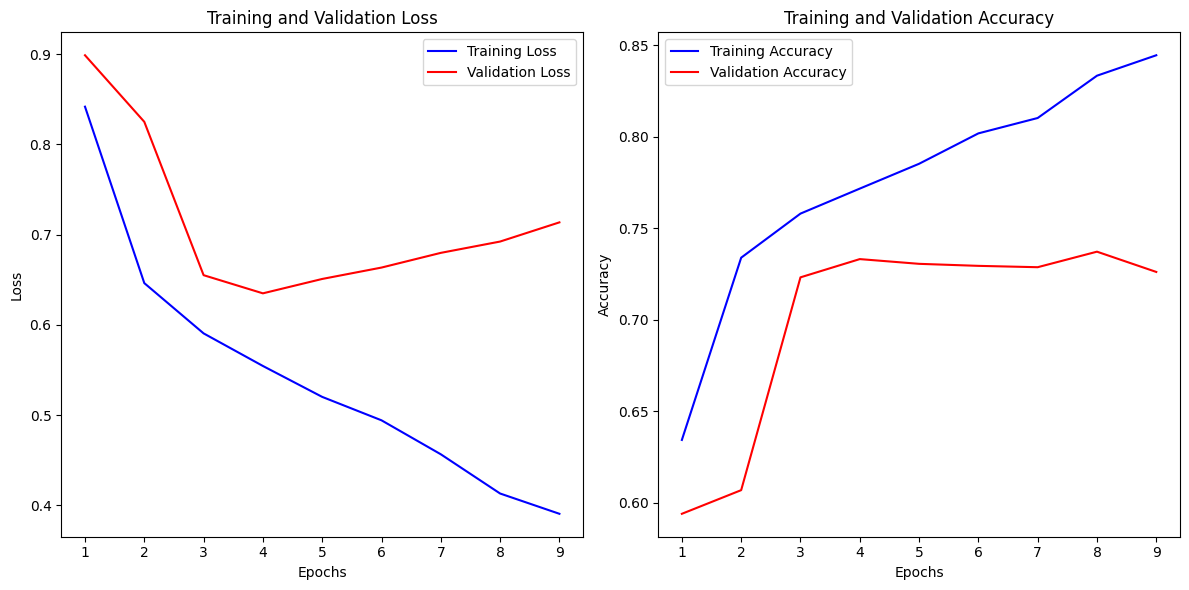

In [43]:
import matplotlib.pyplot as plt
y_pred = model_tfidf.predict(X_test_tfidf_truncated)
y_pred_classes = y_pred.argmax(axis=1)
y_test_classes = y_test_tfidf_.argmax(axis=1)

report = classification_report(y_test_classes, y_pred_classes)
print("Accuracy:", accuracy_score(y_test_classes, y_pred_classes))
print(report)


# Extract metrics from the history object
history_dict = train_model.history

# Loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Accuracy
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

# Number of epochs
epochs = range(1, len(loss) + 1)

# Plot Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# MACHINE LEARNING APPROACH


In [44]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, RidgeClassifierCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
# Single split for train, validation, and test sets
def train_model (classifier, X_train, y_train, X_val, y_val, X_test, y_test):
    model = classifier.fit(X_train, y_train)
    train_pred = classifier.predict(X_train)
    val_pred = classifier.predict(X_val)    
    test_pred = classifier.predict(X_test)
    
    print("Train Accuracy:", accuracy_score(y_train, train_pred))
    print("Validation Accuracy:", accuracy_score(y_val, val_pred))
    print("Test Accuracy:", accuracy_score(y_test, test_pred))
    return model



NAIVE BAYES

In [45]:
# naive bayes
nb = MultinomialNB()
print("Naive Bayes")
print("TF-IDF")
train_model(nb, X_data_tfidf, y_train_tfidf, X_val_tfidf, y_val_tfidf, X_test_tfidf, y_test_tfidf)
print("\nToken Index")
train_model(nb, x_train_ml, y_train_ml, x_val_ml, y_val_ml, x_test_ml, y_test_ml)

Naive Bayes
TF-IDF
Train Accuracy: 0.7648470305938813
Validation Accuracy: 0.7139165743816906
Test Accuracy: 0.7216685123661868

Token Index
Train Accuracy: 0.21355728854229153
Validation Accuracy: 0.2129937246216316
Test Accuracy: 0.2174234034699151


MultinomialNB()

LOGISTIC REGRESSION

In [46]:
# logistic regression
lr = LogisticRegression(max_iter=1000)
print("Logistic Regression")
print("TF-IDF")
train_model(lr, X_data_tfidf, y_train_tfidf, X_val_tfidf, y_val_tfidf, X_test_tfidf, y_test_tfidf)
print("\nToken Index")
train_model(lr, x_train_ml, y_train_ml, x_val_ml, y_val_ml, x_test_ml, y_test_ml)


Logistic Regression
TF-IDF
Train Accuracy: 0.8062387522495501
Validation Accuracy: 0.7445551864156515
Test Accuracy: 0.7456626061277224

Token Index
Train Accuracy: 0.6045406303354713
Validation Accuracy: 0.5921004060538945
Test Accuracy: 0.5946843853820598


C:\Users\RAZER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

SUPPORT VECTOR MACHINE

In [54]:
#support vector machine
svc = SVC(kernel= 'rbf')
print("Support Vector Machine")
print("TF-IDF")
model = train_model(svc, X_data_tfidf, y_train_tfidf, X_val_tfidf, y_val_tfidf, X_test_tfidf, y_test_tfidf)
pickle.dump(model, open("svm_model.pkl", "wb"))
print("\nToken Index")
train_model(svc, x_train_ml, y_train_ml, x_val_ml, y_val_ml, x_test_ml, y_test_ml)

#since SVM has a highest accuracy, we will use it for the final model

Support Vector Machine
TF-IDF
Train Accuracy: 0.902311845323243
Validation Accuracy: 0.7478774455518642
Test Accuracy: 0.7515688445921004

Token Index
Train Accuracy: 0.6271976373955978
Validation Accuracy: 0.593576965669989
Test Accuracy: 0.592469545957918


SVC()

RANDOM FOREST

In [48]:
#random forest classifier
forest = RandomForestClassifier()
print("Random Forest Classifier")
print("TF-IDF")
train_model(forest, X_data_tfidf, y_train_tfidf, X_val_tfidf, y_val_tfidf, X_test_tfidf, y_test_tfidf)
print("\nToken Index")
train_model(forest, x_train_ml, y_train_ml, x_val_ml, y_val_ml, x_test_ml, y_test_ml)


Random Forest Classifier
TF-IDF
Train Accuracy: 0.9811268515527664
Validation Accuracy: 0.7209302325581395
Test Accuracy: 0.7283130306386121

Token Index
Train Accuracy: 0.9860181809791888
Validation Accuracy: 0.6256921373200443
Test Accuracy: 0.6304909560723514


RandomForestClassifier()

RIDGE CLASSIFIER

In [49]:
#ridge classifier
ridge = RidgeClassifierCV()
print("Ridge Classifier")
print("TF-IDF")
train_model(ridge, X_data_tfidf, y_train_tfidf, X_val_tfidf, y_val_tfidf, X_test_tfidf, y_test_tfidf)
print("\nToken Index")
train_model(ridge, x_train_ml, y_train_ml, x_val_ml, y_val_ml, x_test_ml, y_test_ml)


Ridge Classifier
TF-IDF
Train Accuracy: 0.7683078768861612
Validation Accuracy: 0.7331118493909191
Test Accuracy: 0.7375415282392026

Token Index
Train Accuracy: 0.6043560518665497
Validation Accuracy: 0.5880398671096345
Test Accuracy: 0.5902547065337763


RidgeClassifierCV()

In [50]:


# Base classifiers with pipelines for selective scaling
# Since Random Forest and AdaBoost do not require scaling, we only scale the Logistic Regression and also after some experiments, we see that Logistic Regression is the best model for this dataset
# I will try to use stacking classifier with Logistic Regression as the final estimator to see if it can improve the accuracy
# And the data I'm using is the TF-IDF data since it has a higher accuracy than the Token Index data

# Base classifiers with pipelines for selective scaling
base_classifiers = [
    ('Random Forest', RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1)),
    ('AdaBoost', AdaBoostClassifier(n_estimators=100)),
    ('SVM', Pipeline([
        ('scaler', StandardScaler(with_mean=False)),  # Scaling is necessary for SVM
        ('svm', SVC(kernel='rbf', class_weight='balanced'))  # Excluding probability=True for faster training
    ]))
]

# Final estimator with class weights
final_estimator = LogisticRegression(max_iter=5000, solver='saga', class_weight='balanced')

# Stacking classifier
stacking_classifier = StackingClassifier(
    estimators=base_classifiers,
    final_estimator=final_estimator
)

# Cross-validation for the entire stacking pipeline
print("Performing cross-validation...")
scores = cross_val_score(stacking_classifier, X_data_tfidf, y_train_tfidf, cv=5, n_jobs=-1)  # Parallelize cross validation
print("Cross-Validation Accuracy:", np.mean(scores))

# Train the stacking classifier on the full training data
print("Training the stacking classifier...")
stacking_classifier.fit(X_data_tfidf, y_train_tfidf)

# Evaluate on validation set
print("Evaluating on validation set...")
y_pred = stacking_classifier.predict(X_val_tfidf)
print("Accuracy on Validation:", accuracy_score(y_val_tfidf, y_pred))
print("Classification Report:\n", classification_report(y_val_tfidf, y_pred))

pickle.dump(stacking_classifier, open("stacking_classifier.pkl", "wb"))

Performing cross-validation...
Cross-Validation Accuracy: 0.7021362696928712
Training the stacking classifier...


C:\Users\RAZER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\RAZER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\RAZER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent th

Evaluating on validation set...
Accuracy on Validation: 0.7028423772609819
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.70      0.67       636
           1       0.34      0.47      0.39       464
           2       0.90      0.77      0.83      1609

    accuracy                           0.70      2709
   macro avg       0.63      0.65      0.63      2709
weighted avg       0.75      0.70      0.72      2709



# Inference Model with input test

In [59]:
def preprocess_raw_input(raw_input, tokenizer):
    # Tokenize and preprocess input text
    input_text_pre = list(tf.keras.preprocessing.text.text_to_word_sequence(raw_input))
    input_text_pre = " ".join(input_text_pre)
    input_text_pre_accent = ViTokenizer.tokenize(input_text_pre)
    print("Text preprocessed: ", input_text_pre_accent)
    
    # Convert text to sequences and pad for deep learning model
    tokenized_data_text = tokenizer.texts_to_sequences([input_text_pre_accent])
    vec_data_deep = pad_sequences(tokenized_data_text, padding='post', maxlen=250)
    
    # Flatten the padded sequence for machine learning model
    vec_data_ml = tf_idf_vectorizer.transform([input_text_pre_accent]) #dimension is 5000
    vec_data_tf_truncated = TruncatedSVD_vector.transform(vec_data_ml) #scale it down to 1000
    return vec_data_deep, vec_data_ml, vec_data_tf_truncated

def inference_model(input_feature, model):
    # Predict with deep learning model
    output = model(input_feature).numpy()[0]
    result = output.argmax()
    conf = float(output.max())
    label_dict = {'tiêu cực': 0, 'trung lập': 1, 'tích cực': 2}
    label = list(label_dict.keys())
    return label[int(result)], conf

def inference_model_ml(input_feature, model):
    # Predict with machine learning mode

    prediction = model.predict(input_feature)[0]
    return prediction

def prediction(raw_input, tokenizer, model_deep1,model_deep2, model_ml_1, model_ml_2):
    input_deep_token, input_ml, input_deep_tfidf = preprocess_raw_input(raw_input, tokenizer)



    result1, conf1 = inference_model(input_deep_token, model_deep1)
    result2,cnf2 = inference_model(input_deep_tfidf, model_deep2)
    # Machine learning model prediction
    result3 = inference_model_ml(input_ml, model_ml_1)
    result4 = inference_model_ml(input_ml, model_ml_2)  
    # Map the result to label
    label_dict = {0: 'tiêu cực', 1: 'trung lập', 2: 'tích cực'}
    return result1, conf1,result2, cnf2, label_dict[result3], label_dict[result4]

# Load models and tokenizer
my_model_deep1 = load_model('best_token_model.keras')
my_model_deep2 = load_model('deep_tfidf_model.keras')
my_model_ml_1 = pickle.load(open("stacking_classifier.pkl", "rb"))
my_model_ml_2 = pickle.load(open("svm_model.pkl", "rb"))

with open(r"tokenizer_data.pkl", "rb") as input_file:
    my_tokenizer = pickle.load(input_file)
    
      
      
      
# INPUT HERE
raw_input = "Món ăn này ngon quá"
result1, conf1, result2, conf2, result3, result4 = prediction(raw_input, my_tokenizer, my_model_deep1, my_model_deep2, my_model_ml_1, my_model_ml_2)


print("Deep Learning Model Prediction with Token Index Approach:", result1, conf1)
print("Deep Learning Model Prediction with TF-IDF Approach:", result2, conf2)
print("Stack Model Prediction:", result2)
print("SVM Model Prediction:", result4)


Text preprocessed:  món ăn này ngon quá
Deep Learning Model Prediction with Token Index Approach: tích cực 0.9539613723754883
Deep Learning Model Prediction with TF-IDF Approach: tích cực 0.7227433919906616
Stack Model Prediction: tích cực
SVM Model Prediction: tích cực
